# 1. Load dan Labelling

In [2]:
import pandas as pd

# Load dataset hasil scraping
df = pd.read_csv("indodax_reviews.csv")

# Buang komentar kosong
df = df[df['komentar'].str.strip() != '']

# Fungsi pelabelan berdasarkan rating
def beri_label(score):
    if score <= 2:
        return 'negatif'
    elif score == 3:
        return 'netral'
    else:
        return 'positif'

# Buat kolom label
df['label'] = df['rating'].apply(beri_label)

# Tampilkan distribusi awal label
print(df['label'].value_counts())


label
positif    22296
negatif     2225
netral       479
Name: count, dtype: int64


# 2. Text Cleaning + Normalization

In [4]:
import re

def bersihkan_teks(teks):
    teks = str(teks).lower()                          # Lowercase
    teks = re.sub(r'http\S+|www.\S+', '', teks)       # Hapus URL
    teks = re.sub(r'<.*?>', '', teks)                 # Hapus HTML tag
    teks = re.sub(r'[^a-zA-Z\s]', '', teks)           # Hapus simbol dan angka
    teks = re.sub(r'\s+', ' ', teks).strip()          # Hapus spasi berlebih
    return teks

df['komentar_bersih'] = df['komentar'].apply(bersihkan_teks)

# Cek sampel
print(df[['komentar', 'komentar_bersih']].sample(5))


                                                komentar  \
15495  Aplikasi sudah ok bgt..jelas..enak digunakan.....   
1619             sedikit sedikit lama lama menjadi bukit   
11522    Good and easy to install ...succses for Indodax   
4254                                    Baru Update lagi   
12003      Tolong turunkan minimal withdraw menjadi 0,01   

                                         komentar_bersih  
15495  aplikasi sudah ok bgtjelasenak digunakansmoga ...  
1619             sedikit sedikit lama lama menjadi bukit  
11522       good and easy to install succses for indodax  
4254                                    baru update lagi  
12003           tolong turunkan minimal withdraw menjadi  


# 3. Rebalancing Dataset (Undersample & Oversample)

In [6]:
# Pisahkan per kelas
positif = df[df['label'] == 'positif']
negatif = df[df['label'] == 'negatif']
netral  = df[df['label'] == 'netral']

# Undersample positif (ambil sebagian)
positif_sampled = positif.sample(n=5000, random_state=42)

# Oversample negatif dan netral dengan duplikasi
negatif_oversampled = pd.concat([negatif] * 3, ignore_index=True)  
netral_oversampled  = pd.concat([netral] * 10, ignore_index=True)   

# Gabungkan semua
df_seimbang = pd.concat([positif_sampled, negatif_oversampled, netral_oversampled], ignore_index=True)

# Shuffle agar acak
df_seimbang = df_seimbang.sample(frac=1, random_state=42).reset_index(drop=True)

# Cek hasil
print(df_seimbang['label'].value_counts())


label
negatif    6675
positif    5000
netral     4790
Name: count, dtype: int64


# 4. Ekstraksi Fitur TF-IDF + Split Data Training/Testing

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Inisialisasi TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Transformasi komentar bersih ke dalam bentuk numerik
X = vectorizer.fit_transform(df_seimbang['komentar_bersih'])

# Label target
y = df_seimbang['label']

# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Cek jumlah data
print(f"Jumlah data latih : {X_train.shape[0]}")
print(f"Jumlah data uji   : {X_test.shape[0]}")


Jumlah data latih : 13172
Jumlah data uji   : 3293


# 5. Modelling

In [10]:
from sklearn.linear_model import LogisticRegression

# Inisialisasi model
model = LogisticRegression(max_iter=1000)

# Latih model dengan data training
model.fit(X_train, y_train)

# Prediksi pada data testing
y_pred = model.predict(X_test)


# 6. Evaluation

Akurasi Model: 0.9159

Classification Report:

              precision    recall  f1-score   support

     negatif       0.91      0.92      0.92      1335
      netral       0.89      0.92      0.91       958
     positif       0.95      0.90      0.92      1000

    accuracy                           0.92      3293
   macro avg       0.92      0.92      0.92      3293
weighted avg       0.92      0.92      0.92      3293



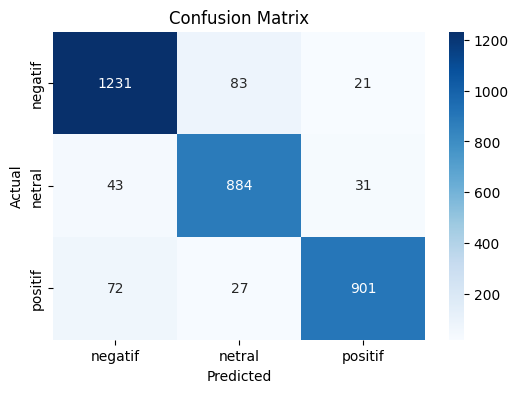

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung akurasi
akurasi = accuracy_score(y_test, y_pred)
print(f"Akurasi Model: {akurasi:.4f}")

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# 7. Inference 

In [66]:
# Fungsi prediksi komentar baru
def prediksi_sentimen(teks):
    # Bersihkan komentar seperti sebelumnya
    def bersihkan_teks(teks):
        teks = str(teks).lower()
        teks = re.sub(r'http\S+|www.\S+', '', teks)
        teks = re.sub(r'<.*?>', '', teks)
        teks = re.sub(r'[^a-zA-Z\s]', '', teks)
        teks = re.sub(r'\s+', ' ', teks).strip()
        return teks

    # Proses
    teks_bersih = bersihkan_teks(teks)
    tfidf = vectorizer.transform([teks_bersih])
    hasil = model.predict(tfidf)[0]
    return hasil


print(prediksi_sentimen("Aplikasi ini sangat lambat dan tidak berguna"))
print(prediksi_sentimen("Fitur-fiturnya lengkap dan sangat membantu"))
print(prediksi_sentimen("kurang lebih oke lah"))


negatif
positif
netral
